<a href="https://colab.research.google.com/github/titsitits/open-image-restoration/blob/master/Colab_Notebooks/Demo_Image_Restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Restoration Demo

Launch each cell by pressing the play-button on the left.


In [2]:
#@title 1. Upload images to restore 
#@markdown (can be buggy. Simply relanuch the cell in case of a bug)

import os
from os.path import *
basedir = "/content"



#print("Ensure you are using a GPU (otherwise change execution mode to GPU")
#print("You can also verify you have a powerful GPU (Tesla P4 < K80 < T4 < P100")

#!nvidia-smi -L

# Import library
repodir = join(basedir,"open-image-restoration")
if not exists(repodir):
  os.chdir(basedir)
  !git clone -q https://github.com/titsitits/open-image-restoration {repodir} > out.log

  os.chdir(repodir)

  #Todo: create a pip module
  #Specific dependencies needed for colorization
  !pip install -q -q -q -r requirements.txt > out.log

os.chdir(repodir)
import ImagePipeline_utils as IP
import ImageRestorer
restorer = ImageRestorer.ImageRestorer()



#Import some files
inputdir = join(basedir,"input")
IP.initdir(inputdir)
outputdir = join(basedir,"output")
IP.initdir(outputdir)



import_local_files = True

url1 = "https://raw.githubusercontent.com/titsitits/titsitits.github.io/master/image_restoration/images/boxe%20goffaux%20bocqu%C3%A9.jpg"
####@param {type:"string"}
url2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/AnneFrank1940_crop.jpg/524px-AnneFrank1940_crop.jpg"
####@param {type:"string"}
url3 = "https://upload.wikimedia.org/wikipedia/commons/6/60/Christmas_Truce_3.jpg"
####@param {type:"string"}


from google.colab import files
os.chdir(inputdir)
if import_local_files:
  files.upload()
else:
  !wget -q -O "1.jpg" {url1}
  !wget -q -O "2.jpg" {url2}
  !wget -q -O "3.jpg" {url3}
os.chdir(basedir)

from IPython.display import clear_output

clear_output()
print("Images uploaded. Use the cell below to restore them.")

Images uploaded. Use the cell below to restore them.


Image preprocessing...: finished in 0.0102 s
Removing stripes...: finished in 19.9850 s
Colorizing...: finished in 18.6086 s
Super-resolving...: finished in 6.8076 s


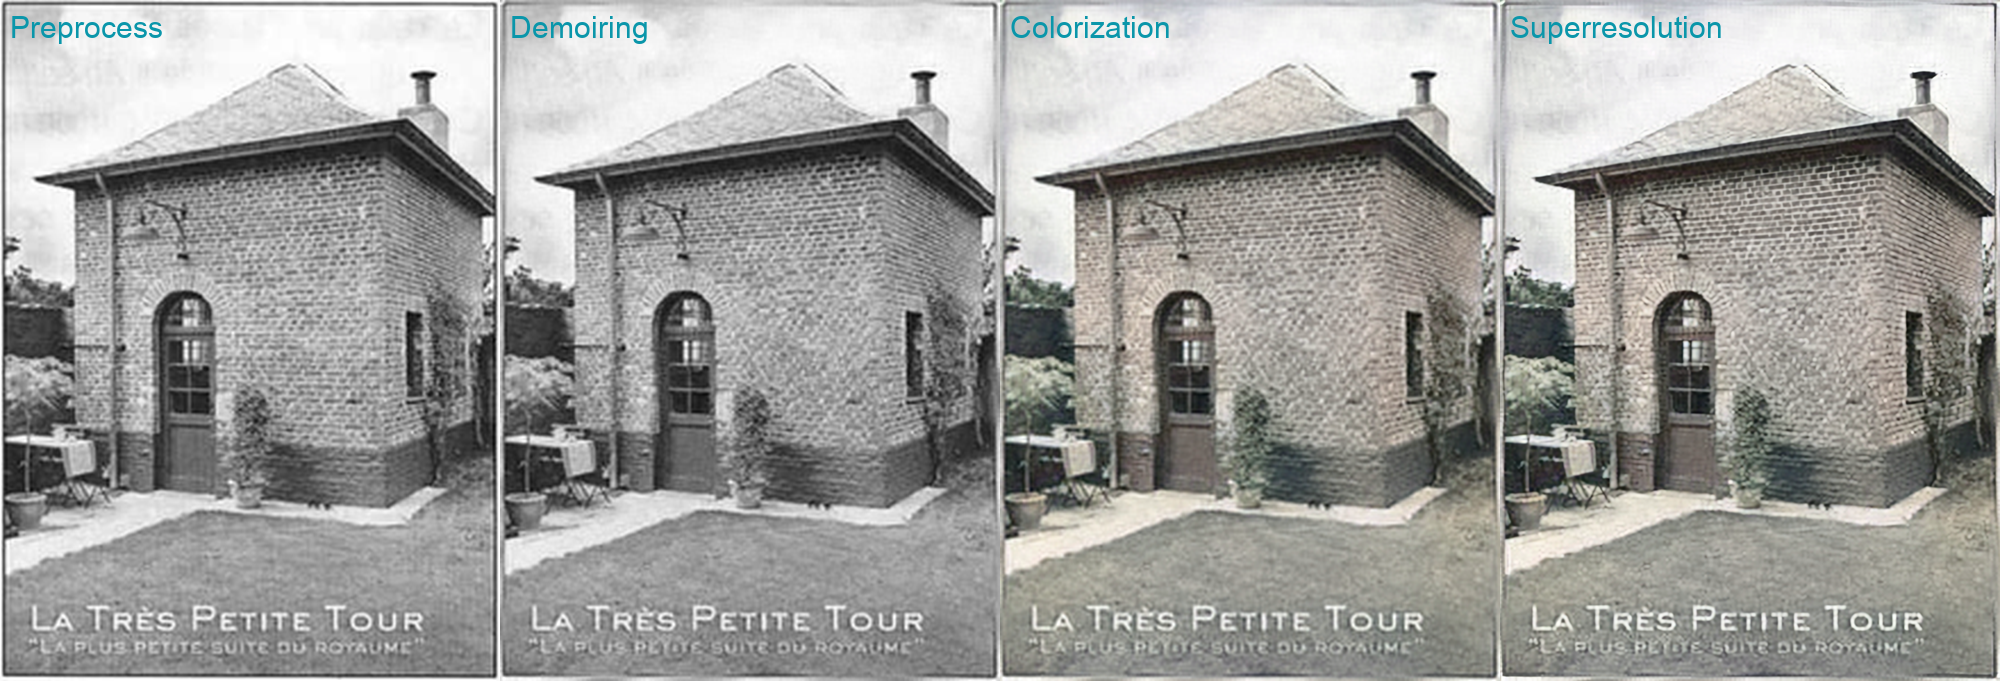

In [8]:
#@title 2. Choose any restoration technique to apply on images

#@markdown Note that the denoising method is still experimental and unstable.

#@markdown ---

#Todo: make restorer available from outside repo directory
os.chdir(repodir)
#Todo: improve log handling
raising = False

Demoiring = True#@param {type:"boolean"}
Denoising = False#@param {type:"boolean"}
Colorization = True#@param {type:"boolean"}
Superresolution = True#@param {type:"boolean"}
#@markdown ---
initial_size = 400 #@param {type:"slider", min:0, max:700, step:1 }

dirs = []
# Restore images
preprocessdir = join(outputdir, "Preprocess")
dirs.append(preprocessdir)
#Initializa images (maximum 400x400px, grayscale)
restorer.preprocess(inputdir, outputdir = preprocessdir, gray=True, size = (initial_size,initial_size))

if Demoiring:
  demoirdir = join(outputdir, "Demoiring")  
  dirs.append(demoirdir)
  restorer.remove_stripes(outputdir=demoirdir, raising=raising, process_args = '-n 3')

if Denoising:  
  denoisedir = join(outputdir, "Denoising") 
  dirs.append(denoisedir)
  restorer.denoise(outputdir=denoisedir, raising=raising) #remove image grain

if Colorization:  
  colordir = join(outputdir, "Colorization") 
  dirs.append(colordir)
  restorer.colorize(outputdir = colordir) #colorize image (first time takes a long time as large models must be downloaded)

if Superresolution:  
  superresdir = join(outputdir, "Superresolution") 
  dirs.append(superresdir)
  restorer.super_resolution(outputdir = superresdir, raising=raising) #upsample image

#@markdown ---

IP.compare_folders(dirs, imagewidth=500, sameheight = False, labelcolor = (10,150,170))

# Display image crops

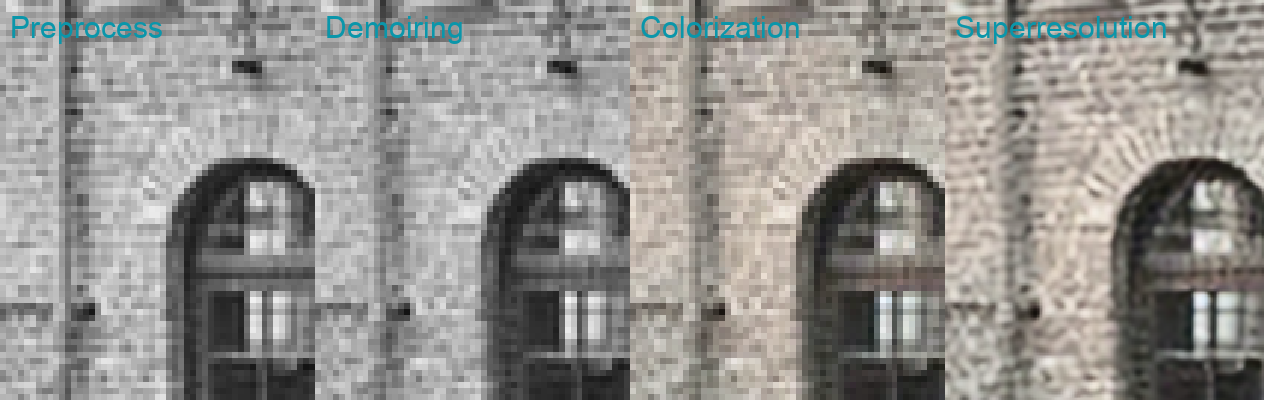

In [48]:
#@title Crop coordinate limits (% of image width and height): {run: "auto"}


import PIL
imfiles = IP.get_filenames(preprocessdir)
image_file = "CETIC 2 (889).png" #@param {type:"string"}
if image_file not in imfiles:
  print("Valid image_file:", imfiles)
  #@markdown ---
else:
  left = 18 #@param {type:"slider", min:0, max:100, step:1 }
  right = 42 #@param {type:"slider", min:0, max:100, step:1}
  bottom = 34 #@param {type:"slider", min:0, max:100, step:1}
  upper = 56 #@param {type:"slider", min:0, max:100, step:1}
  #@markdown ---
  display_size = 400 #@param {type:"slider", min:0, max:1000, step:1}
  if left > right:
    print("Left corner cannot be higher than right corner!")
  elif bottom > upper:
    print("Bottom corner cannot be higher than upper corner!")
  else:
    crops = []

    for d in dirs:
      im = PIL.Image.open(join(d,image_file))
      left_lim = left/100*im.width    
      right_lim = right/100*im.width  
      bottom_lim = bottom/100*im.height
      upper_lim = upper/100*im.height

      new_width = int(right_lim-left_lim)
      new_height = int(upper_lim - bottom_lim)
      ratio = display_size/new_height
      new_width = int(new_width*ratio)
      new_height = int(display_size)

      if left > right:
        print()
      #we invert upper and lower in arguments, because coordinates are from left-upper corner!
      crops.append(im.crop((int(left_lim), int(bottom_lim), int(right_lim), int(upper_lim))).resize((new_width,new_height)))
    steps = ['Preprocess','Demoiring', 'Colorization','Superresolution']
    IP.display_images(crops, labels = steps, labelcolor = (10,150,170))

    cropsdir = "/content/crops"
    IP.createdir_ifnotexists(cropsdir)

    for c,s  in zip(crops, steps):
      
      IP.createdir_ifnotexists(join(cropsdir, s))
      c.save(join(cropsdir, s, image_file))
#@markdown ---